# Forecasting Game

>#### Carl Somers - 19422704

1. Guess the forecast of three macroeconomic series for the US economy (FED St. Louis): GDP, CPI, and Unemployment rate. You have to guess the values for September, October, and November.
2. Provide the forecast (using ARIMA models) of three macroeconomic series for the US economy (FED St. Louis): GDP, CPI, and Unemployment rate. You have to forecast values for September, October,  and November.
3. Using appropriate tests, check the guessed valued and forecasted values for September and October for CPI and Unemployment Rate.

#### Load in Dependancies 

In [261]:
# Data Loading & Handelling 
from fredapi import Fred
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

# Modelling & GridSearch
from itertools import product as prod
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
import statsmodels.tsa as tsa
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as stats

# Testing
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import q_stat, acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera

# Metrics/Forecast Evaluation
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

import warnings
import pandoc
warnings.filterwarnings("ignore")

#### Download Data Using FRED API 

In [2]:
fred = Fred(api_key = "e1d6df5228083eabdd27bd113d0214c1")

macro = pd.DataFrame()
macro["UNR"] = fred.get_series("UNRATE")
macro["CPI"] = fred.get_series("CPIAUCSL")
macro["GDP"] = fred.get_series("GDP")

Please note that GDP is quarterly while both unemployment and CPI releases are monthly, therefore interpolation is needed

In [3]:
macro = macro.interpolate()
macro.head()

,UNR,CPI,GDP
1948-01-01,3.4,23.68,265.742000
1948-02-01,3.8,23.67,268.017000
1948-03-01,4.0,23.50,270.292000
1948-04-01,3.9,23.82,272.567000
1948-05-01,3.5,24.01,274.776667


In [4]:
macro_early = macro.head(384)
macro = macro.drop(macro_early.index)

In [5]:
macro.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 514 entries, 1980-01-01 to 2022-10-01
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   UNR     514 non-null    float64
 1   CPI     514 non-null    float64
 2   GDP     514 non-null    float64
dtypes: float64(3)
memory usage: 16.1 KB


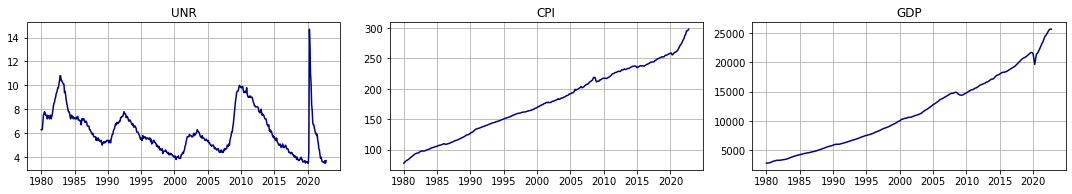

In [6]:
plt.figure(figsize = (15,5))
for i, col in enumerate(macro):
    plt.subplot(2, 3, i+1)
    plt.title(col)
    plt.plot(macro[col], color = "darkblue")
    plt.grid()
    plt.tight_layout()

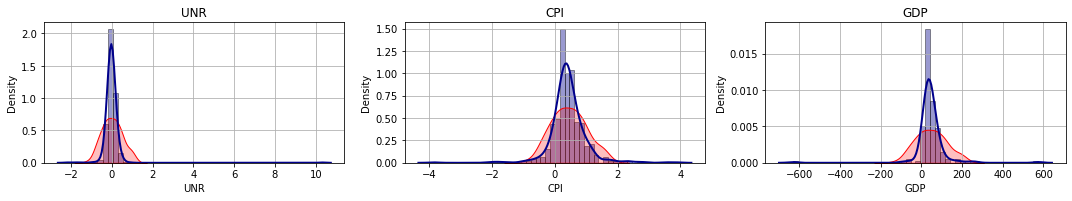

In [7]:
plt.figure(figsize = (15,5))
for i, col in enumerate(macro):
    plt.subplot(2, 3, i+1)
    plt.title(col)
    sns.distplot(macro[col].diff(), hist=True, kde=True, color='darkblue',hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 2})
    np.random.seed(0)
    # Random variable with normal distribution
    normal_sample = np.random.normal(np.mean(macro[col].diff()),np.std(macro[col].diff()), 249)
    # Applying the Gaussian kernel density estimate to get the density curve
    sns.kdeplot(normal_sample, color = 'red', shade=True) 
    plt.grid()
    plt.tight_layout()

Economists love to take log transforms to observe growth/trend within the data, it also presents more intuitive numbers. 
From now on we are observing GDP change, CPI change and Unemployment rate change. 

In [8]:
for col in macro[:3]:
    macro[f"log{col}"] = np.log(macro[col])
macro.head()

,UNR,CPI,GDP,logUNR,logCPI,logGDP
1980-01-01,6.3,78.0,2789.842000,1.840550,4.356709,7.933740
1980-02-01,6.3,79.0,2792.345333,1.840550,4.369448,7.934637
1980-03-01,6.3,80.1,2794.848667,1.840550,4.383276,7.935533
1980-04-01,6.9,80.9,2797.352000,1.931521,4.393214,7.936429
1980-05-01,7.5,81.7,2817.062333,2.014903,4.403054,7.943450


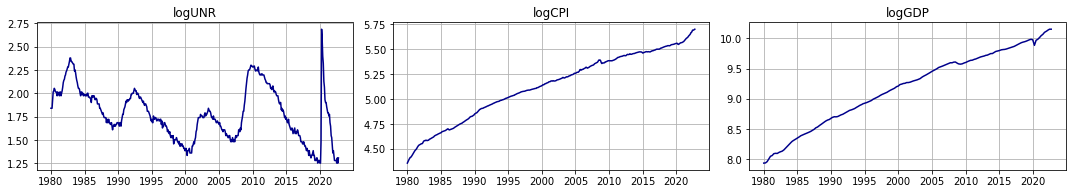

In [9]:
plt.figure(figsize = (15,5))
for i, col in enumerate(macro.iloc[:,3:6]):
    plt.subplot(2, 3, i+1)
    plt.title(col)
    plt.plot(macro[col], color = "darkblue")
    plt.grid()
    plt.tight_layout()

To not introduce bias and ensure model robustness (no overfitting - allow for out of sample testing), we subtract a test set, leaving the rest for training

In [158]:
# Train/Test Split (removing September and October [Oct CPI releases on Nov10])
macro_test = macro.tail(2)
macro_dev = macro.drop(macro_test.index)

In [159]:
macro_dev.tail()

,UNR,CPI,GDP,logUNR,logCPI,logGDP
2022-04-01,3.6,288.663,25248.476,1.280934,5.665260,10.136521
2022-05-01,3.6,291.474,25386.747,1.280934,5.674951,10.141983
2022-06-01,3.6,295.328,25525.018,1.280934,5.688087,10.147414
2022-07-01,3.5,295.271,25663.289,1.252763,5.687894,10.152817
2022-08-01,3.7,295.620,25663.289,1.308333,5.689075,10.152817


In [160]:
macro_test

,UNR,CPI,GDP,logUNR,logCPI,logGDP
2022-09-01,3.5,296.761,25663.289,1.252763,5.692927,10.152817
2022-10-01,3.7,298.062,25663.289,1.308333,5.697302,10.152817


Text(0.5, 1.0, 'Validation and Training Set')

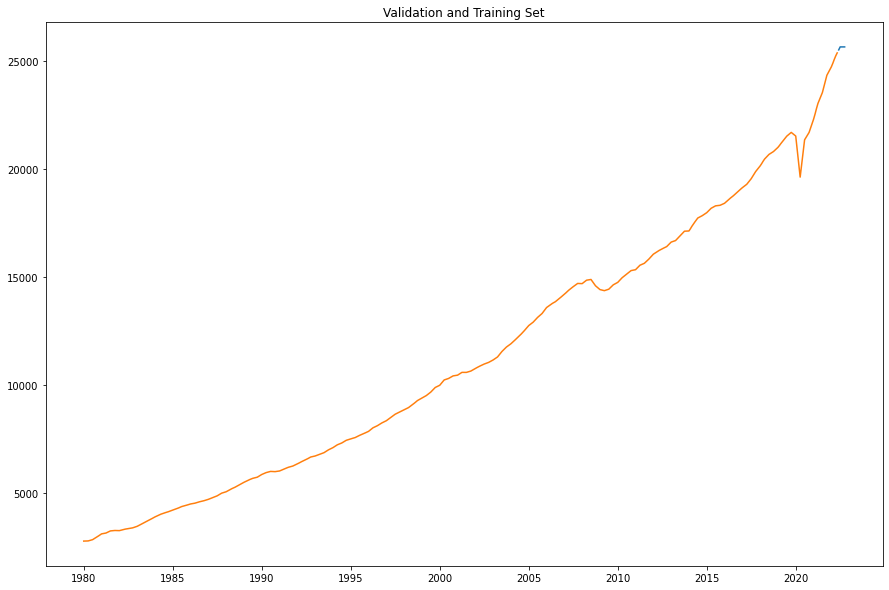

In [13]:
plt.figure(figsize = (15,10))
plt.plot(macro_test["GDP"])
plt.plot(macro_dev["GDP"])
plt.title("Validation and Training Set")

# Box-Jenkins Methodology 

1. Time series identification: In short, we have to find the appropiate values for p,d and q.
2. Model estimation: After having identified the appropiate parameters of the ARIMA model. 
3. Model diagnostic: We have to check that the model residuals follow a white noise distribution.
4. Forecasting: We can project statistical predictive inference. 

## 1. Time Series Identification

#### Testing Stationarity

In [14]:
def dickey_fuller(ts, kind = "ct"):
    """
    Perform & print Dickey-Fuller test for stationarity
    """
    #Perform Dickey-Fuller test:
    df = adfuller(ts, regression = kind, autolag = "AIC")
    df_results = pd.Series(df[0:4], index = ["Test Statistic", 
                                             "P-value", 
                                             "Lags", 
                                             "N"])
    for key, value in df[4].items():
        df_results["Critical Value (%s)"%key] = value
    
    df_results = pd.DataFrame(df_results, columns = [f"{ts.name}"])
        
    return df_results

In [15]:
def stationarity_test(ts, window = 12, kind = "ct"):
    """
    Uses rolling mean and std for plot observation of stationarity
    Performs Dickey-Fuller Test 
    
    Input:
    ts - TimeSeries to be analysed 
    window - Smoothing effect for rolling statistics (default 1 year)
    """
    # Initiating subplots 
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(35, 6), gridspec_kw={'width_ratios': [4, 1]})
    
    # Plotting Time series 
    ax1.plot(ts, color = "darkblue", label = (f"{ts.name}"))
    ax1.set_title(f"{ts.name} Time Series Plot", loc = "left")
    ax1.set_xlabel("Date")
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    # dickey_fuller test and plotting table
    df = round(dickey_fuller(ts, kind), 3)
    ax2.axis('off')
    bbox=[0, 0, 1, 1]
    tab = ax2.table(cellText = df.values, rowLabels = df.index, bbox = bbox, colWidths=[0.1], loc='center', cellLoc='center')
    ax2.set_title(f"{ts.name} Dickey-Fuller Test")
    tab.auto_set_font_size(False)
    tab.set_fontsize(12)
    f.tight_layout()
    
    return plt.show()

### Stationarity - Raw Series

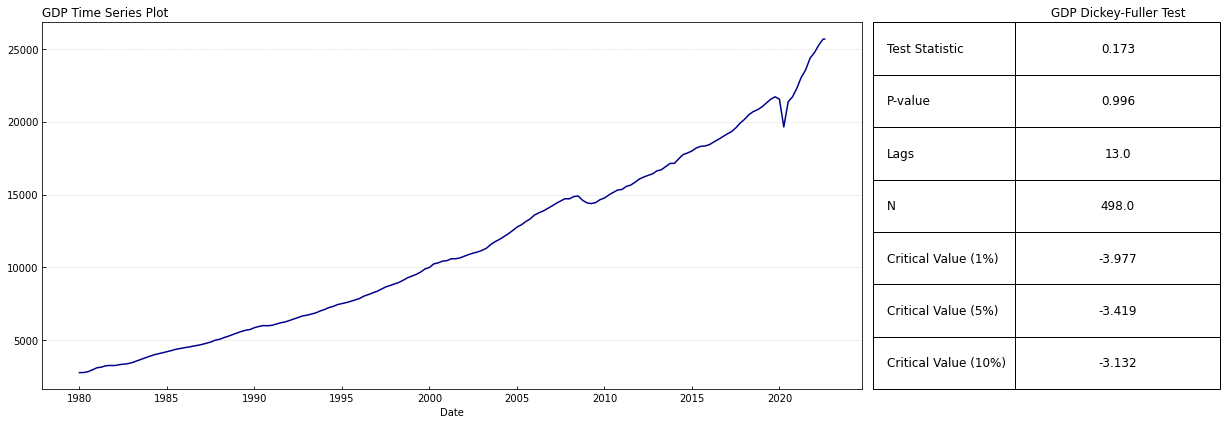

In [260]:
stationarity_test(macro_dev.GDP)

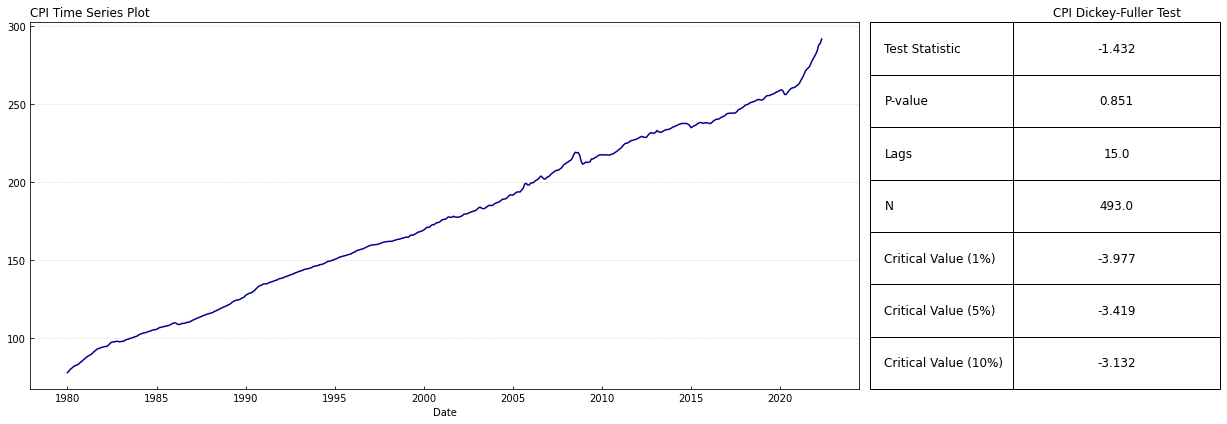

In [16]:
stationarity_test(macro_dev.CPI)

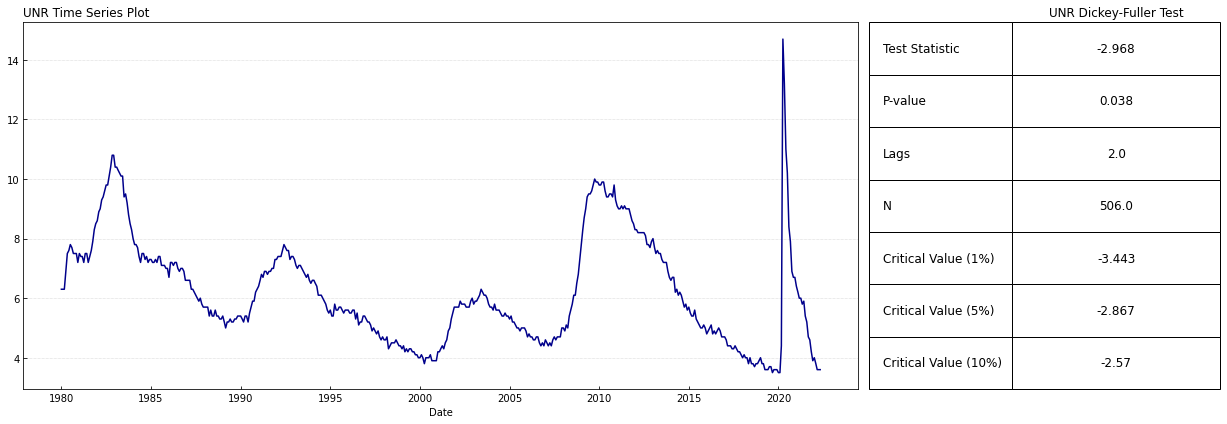

In [17]:
stationarity_test(macro_dev.UNR, kind = "c")

### Stationarity log-transformed Series

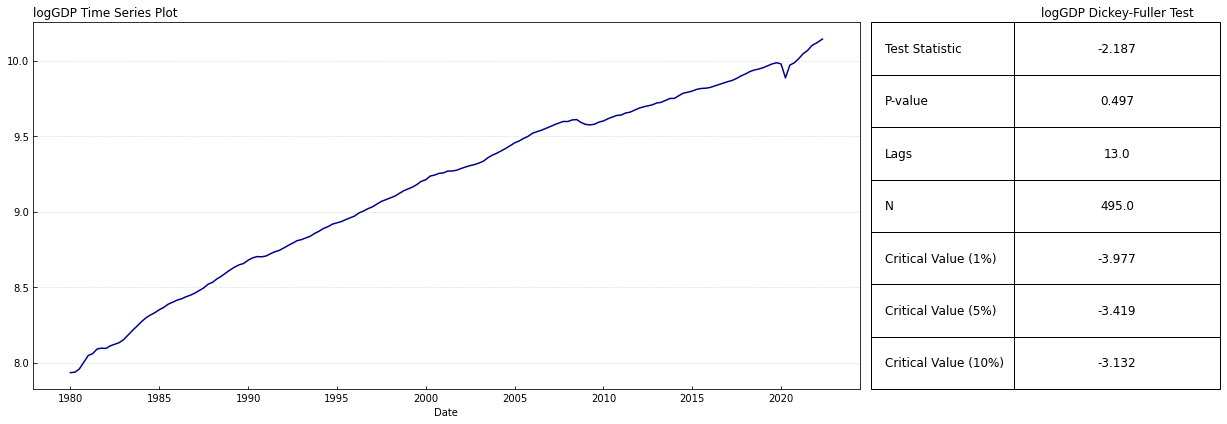

In [18]:
stationarity_test(macro_dev.logGDP)

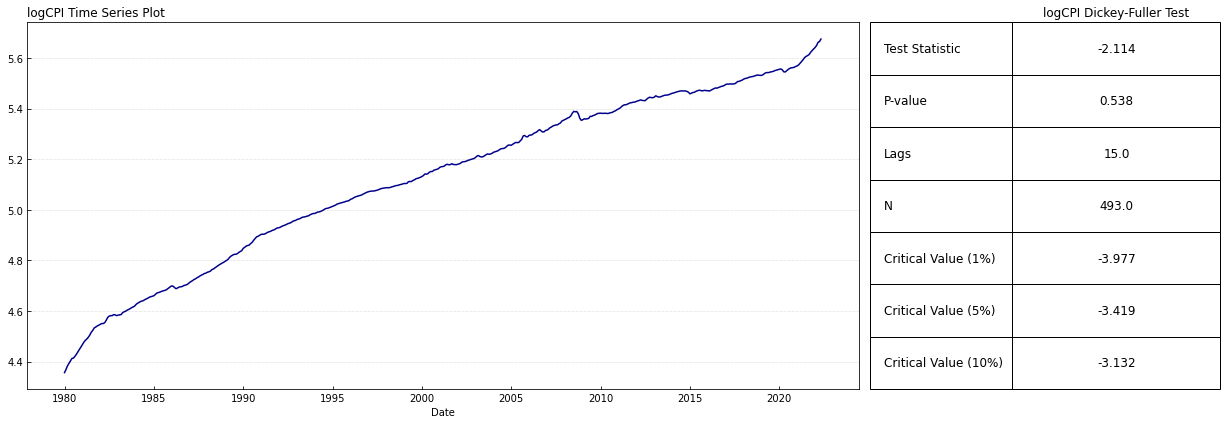

In [19]:
stationarity_test(macro_dev.logCPI)

### Trend Removal 

Positive additive growth pattern. The mean and the variance are clearly not constant. Therefore, we regard it as a non-stationary time series. The dickey-fuller test also rejects that this is stationary at 95 and 99% confidence. Therefore, we will employ differencing to remove the trend. 

In [20]:
def difference_ts(ts):
    """
    Applies differencing to remove series trend
    """
    #ts_diff = ts.diff()
    ts_diff = ts - ts.shift()
    ts_diff.dropna(inplace = True)
    
    return ts_diff

In [21]:
def outlier_fixer(ts):
    """
    Employs interpolation across outliers in dataseries
    """
    q_low = ts.quantile(0.001)
    q_hi  = ts.quantile(0.999)
    
    value = ts[(ts>q_hi)|(ts <q_low)]
    print(value.index)
    ts = ts.replace([value.values], np.NaN)
    ts = ts.interpolate()
    ts.dropna(inplace = True)
    
    return ts

In [22]:
DLGDP = difference_ts(macro_dev.logGDP)
DUNR = difference_ts(macro_dev.logUNR)
DLCPI = difference_ts(macro_dev.logCPI)

In [23]:
DUNR = outlier_fixer(DUNR)
DLGDP = outlier_fixer(DLGDP)

DatetimeIndex(['2020-04-01', '2020-08-01'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2020-04-01', '2020-05-01'], dtype='datetime64[ns]', freq=None)


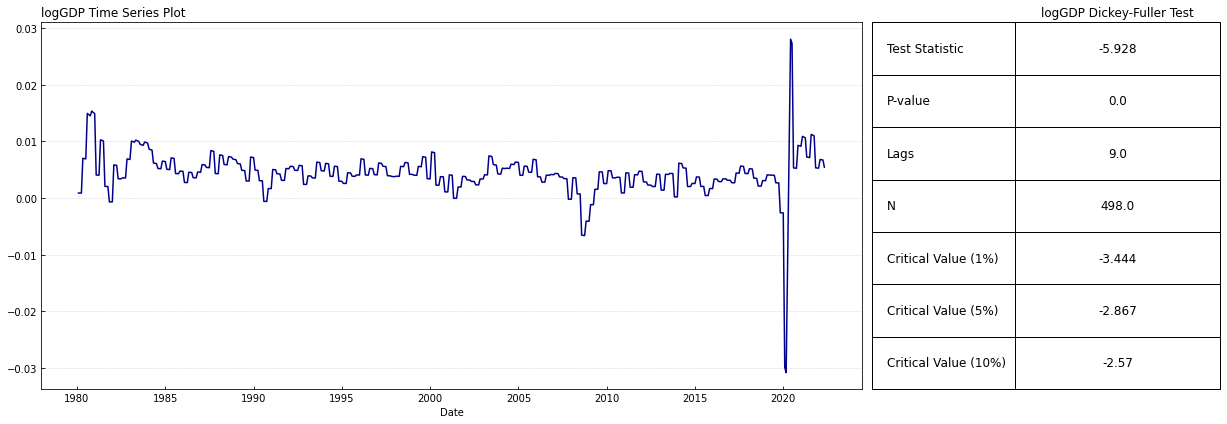

In [24]:
stationarity_test(DLGDP, kind = "c")

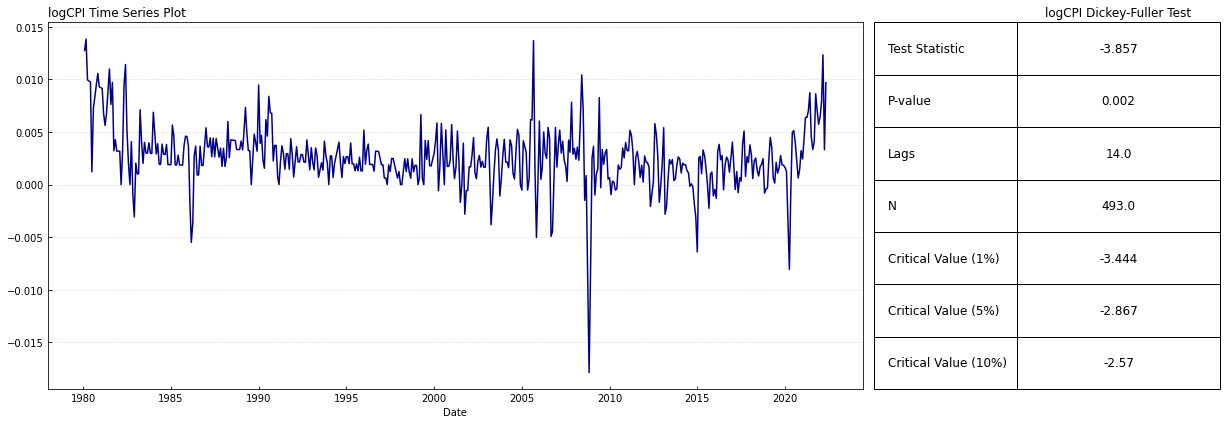

In [25]:
stationarity_test(DLCPI, kind = "c")

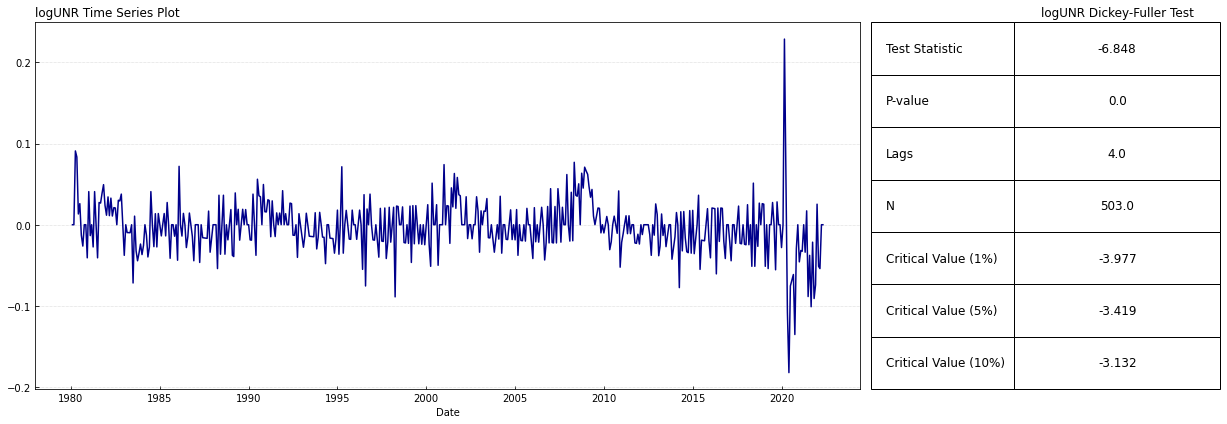

In [26]:
stationarity_test(DUNR)

In [27]:
def acf_plot(data, ax, title = " ", lags = 12):
    """
    Plots Autocorrelation Function
    """
    smt.graphics.plot_acf(data, ax = ax, title = title, zero = False, color = "darkblue", alpha = None, lags = lags, use_vlines = True, vlines_kwargs = {"colors": "darkblue"})
    ax.axhline(y = 2 / np.sqrt(len(data)), color = "red", linestyle = "--")
    ax.axhline(y = -2 / np.sqrt(len(data)), color = "red", linestyle = "--")
    if title != "Autocorrelation Function of Residuals":
        ax.set_title(f"Autocorrelation Function of {data.name}", loc = "left")
    ax.set_ylim(-1, 1)
    ax.set_xlabel("Lags")
    ax.set_ylabel("Autocorrelation")
    ax.tick_params(direction = "in")
    ax.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    return 

In [28]:
def pacf_plot(data, ax, title = "", lags = 12):
    """
    Plots Partial Autocorrelation Function 
    """
    smt.graphics.plot_pacf(data, ax = ax, title = title, zero = False, color = "darkblue", alpha = None, lags = lags, use_vlines = True, vlines_kwargs = {"colors": "darkblue"})
    # Setting conf intervals (95%)
    ax.axhline(y = 2 / np.sqrt(len(data)), color = "red", linestyle = "--")
    ax.axhline(y = -2 / np.sqrt(len(data)), color = "red", linestyle = "--")
    if ax != "":
        ax.set_title(f"Partial Autocorrelation Function of {data.name}", loc = "left")
    ax.set_ylim(-1, 1)
    ax.set_xlabel("Lags")
    ax.set_ylabel("PACF")
    ax.tick_params(direction = "in")
    ax.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    return 

In [29]:
def tsplot(ts, lags = 12, transformation = True):
    """
        Plot time series, its ACF and PACF, calculate Dickets–Fuller test

        ts - timeseries
        lags - how mants lags to include in ACF, PACF calculation
    """
    
    with plt.style.context("default"):
        fig = plt.figure(figsize=(15,8))
        
        # Engaging suplots 
        latsout = (2, 2)
        ts_ax = plt.subplot2grid(latsout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(latsout, (1, 0))
        pacf_ax = plt.subplot2grid(latsout, (1, 1))
        
        # Graphing TS, AFC, PAFC and outputting Dickey-Fuller
        ts_ax.plot(ts, color = "darkblue")
        ts_ax.axhline(y = np.mean(ts), color = "red", linestyle = "--")
        p_value = sm.tsa.stattools.adfuller(ts)[1]
        if transformation is True:
            ts_ax.set_title(f"Differenced {ts.name} Time Series\n Dickey-Fuller: p={round(p_value, 4)}")
        else:
            ts_ax.set_title(f"{ts.name} Time Series\n Dickey-Fuller: p={round(p_value, 4)}")
        acf_plot(ts, ax = acf_ax, lags = lags)
        pacf_plot(ts, ax = pacf_ax, lags = lags)
        ts_ax.grid(axis = "y", linewidth = 0.5, linestyle = ":")
        plt.tight_layout()
    
    return

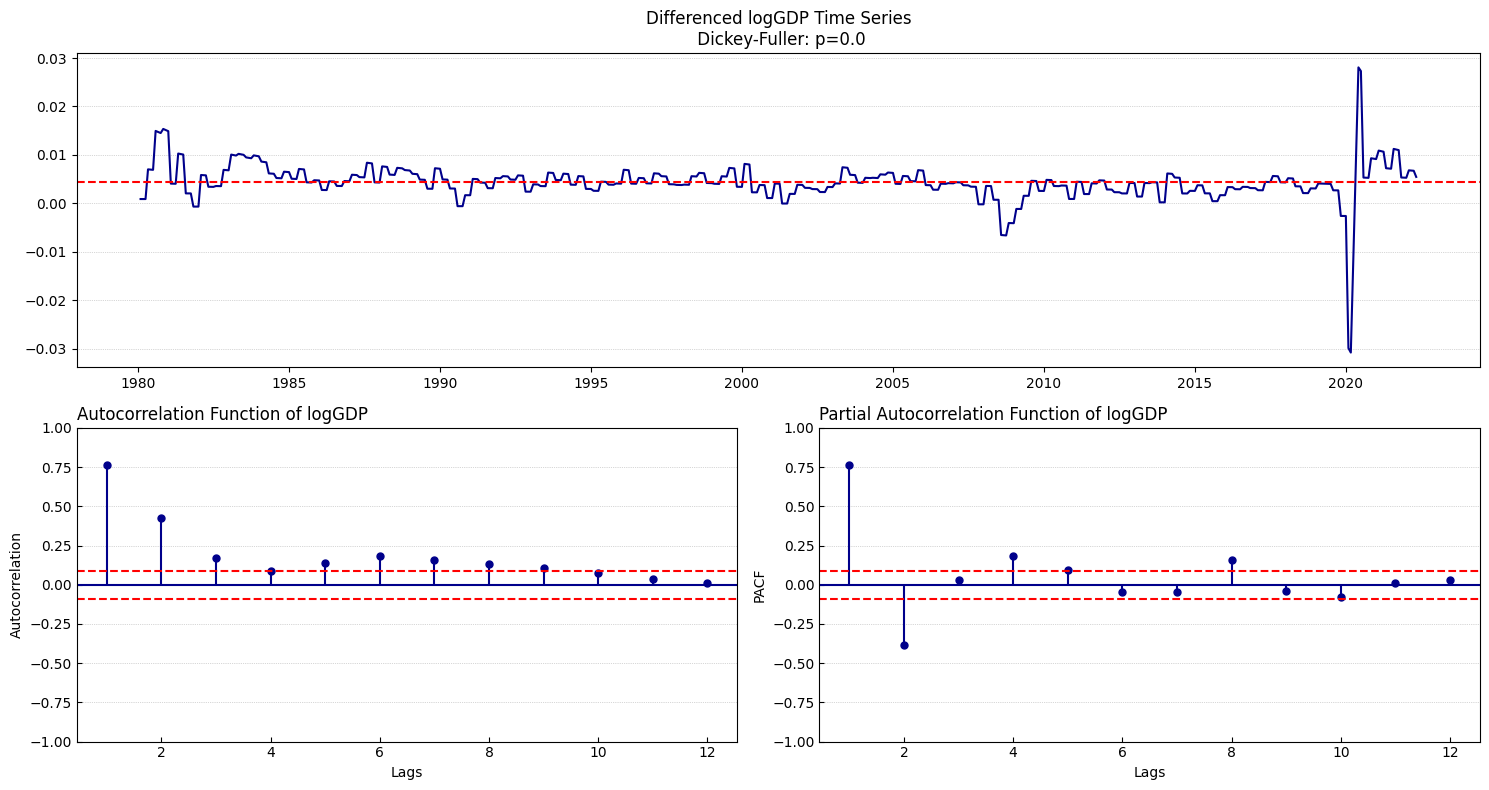

In [30]:
tsplot(DLGDP, lags = 12)

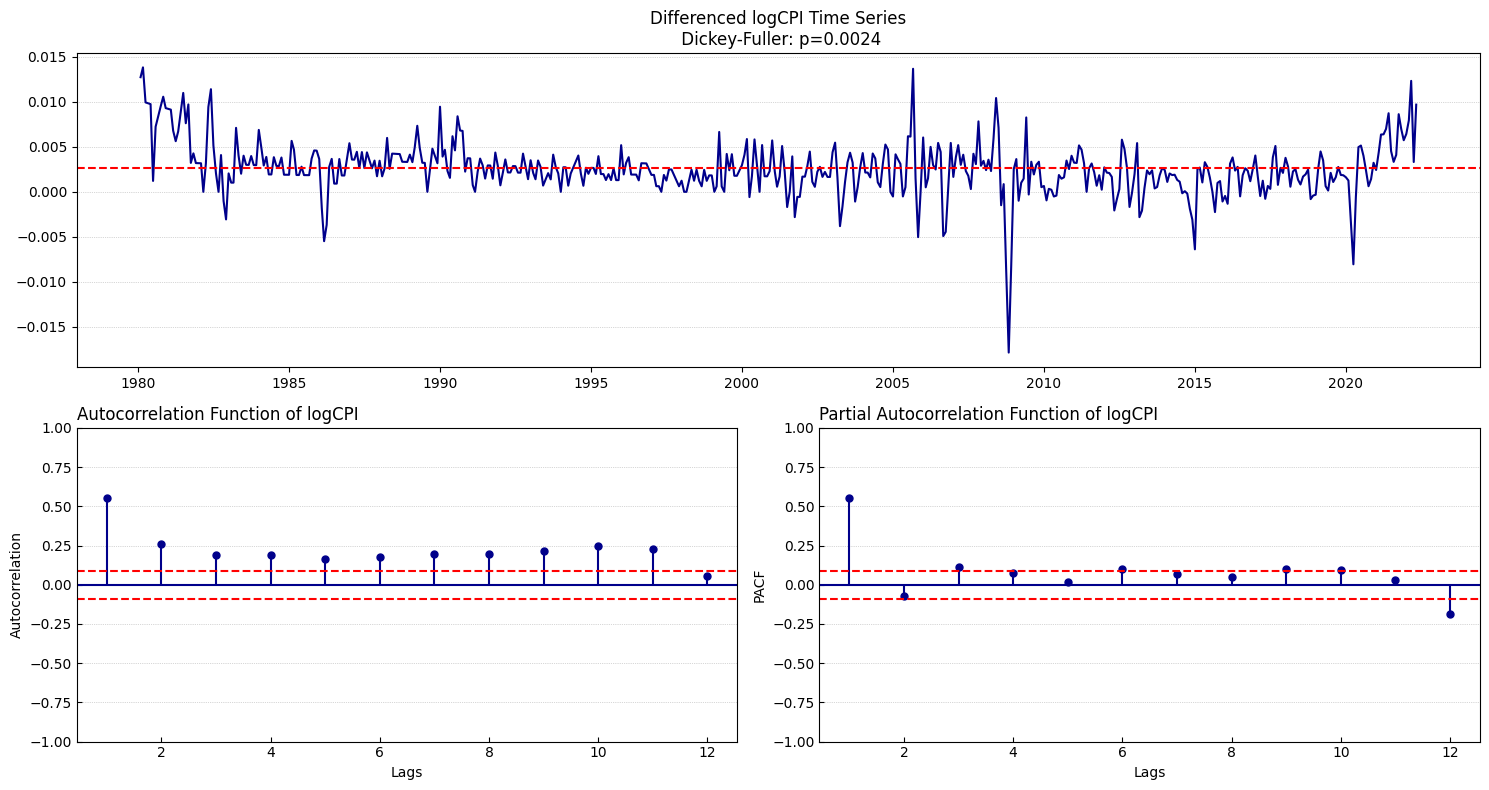

In [31]:
tsplot(DLCPI, lags = 12)

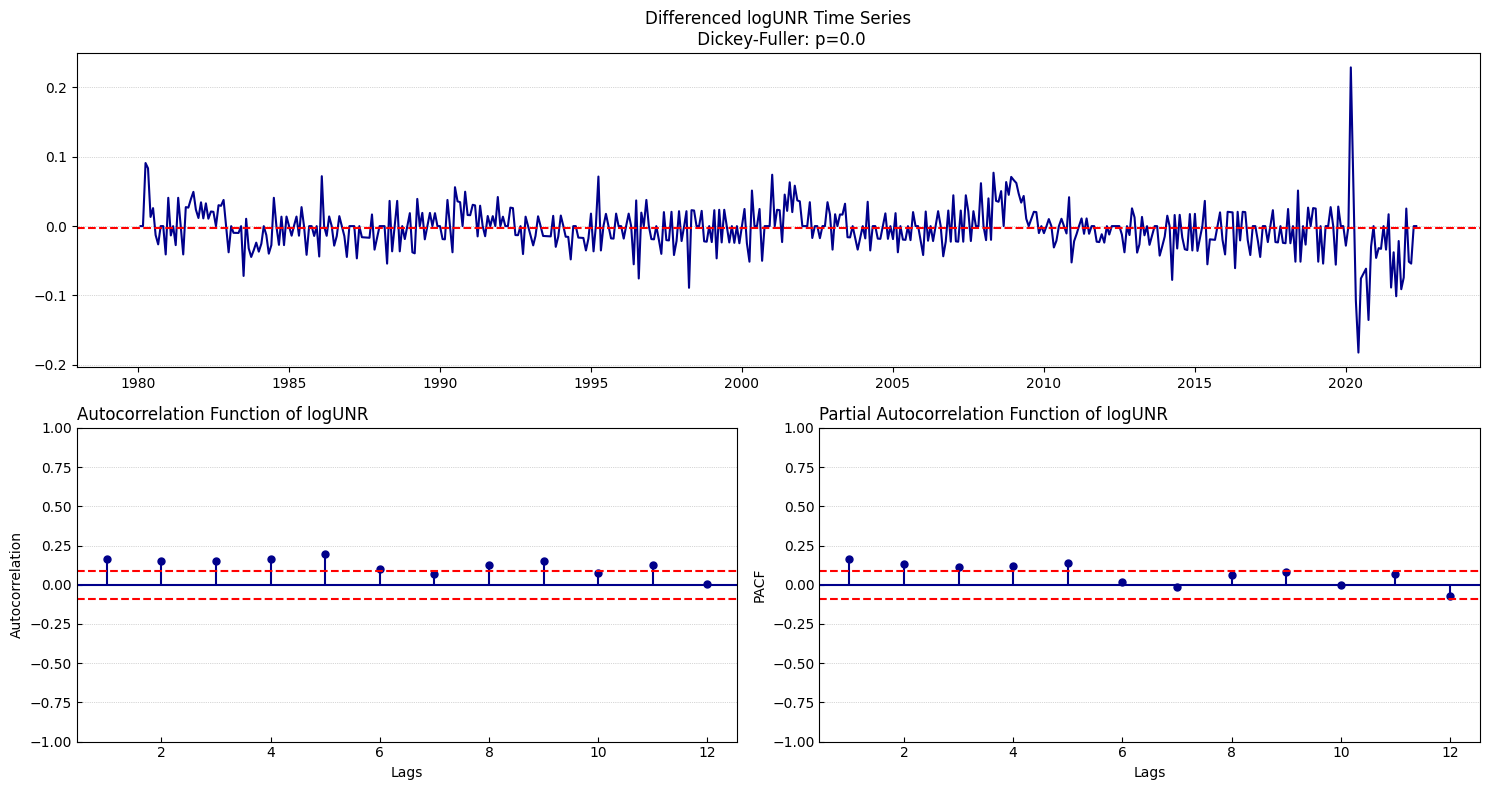

In [33]:
tsplot(DUNR, lags = 12)

A visual examination of the correlogram to lag 50 confirms that the data is clearly non-stationary and follows an accumulative autoregressive growth pattern. It is the expected result for a growing additive time series, with no sesonality. The blue margin shows the 95% confidence interval.

## GridSearch to Optimise Parameters using Information Criteria

#### Parameters

**p** = number of autoregressive terms (AR term)

**d** = how many nonseasonal differences are needed to achieve stationarity

**q** = number of lagged forecast errors in the prediction equation (MA term)

In [34]:
# Setting out ranges of params to check
p, d, q = range(0, 8), range(0,1), range(0, 8)

# all possible combinations of params
params = prod(p, d, q)
len(list(params))

64

In [35]:
def evaluate_model(training, order):
    """
    Training ARIMA models, outputs results and evaluation
    
    Inputs:
    training - training dataset 
    order - current p,d,q param combination
    """
    # Initialising and training 
    model = ARIMA(training, order = order, enforce_stationarity = True)
    model_fit = model.fit()
    y_hat = model_fit.fittedvalues
    
    # Recording data
    temp_model_data = {}
    temp_model_data["y"] = training.copy()
    temp_model_data["y_hat"] = y_hat
    rmse = np.sqrt(model_fit.mse)
    
    return model_fit.aic, model_fit.bic, model_fit.hqic, rmse, temp_model_data, model_fit.resid

In [36]:
def arima_optimise(training, p_grid, d_grid, q_grid):
    """
    Searching for optimal parameters based on AIC 
    
    Inputs:
    training - training dataset 
    p_grid - all p params (range)
    d_grid - all d params (range)
    q_grid - all q params (range)
    """
    best_score, best_cfg = float("inf"), None
    aic_values = list()
    for p in p_grid:
        for q in q_grid:
            for d in d_grid:
                order = (p,d,q)
                try:
                    aic, bic, hqic, rmse, temp_model_data, residuals = evaluate_model(training, order)
                    if aic < best_score:
                        best_score, b_rmse, best_cfg, best_model_data, b_resid = aic, rmse, order, temp_model_data, residuals
                    print(f"> ARIMA {order}; AIC = {round(aic, 2)} , BIC = {round(bic, 2)} , HQIC = {round(hqic, 2)}")
                    aic_values.append(aic)
                except:
                    continue
                    
    # print best model and return best configuration and best scores 
    print("> best model: ARIMA%s with AIC of %.2f" % (best_cfg, best_score))
    return best_cfg, best_model_data, aic_values, b_rmse, b_resid

In [37]:
# Dictionary initialising for data
best_params = {}
model_data = {}
aic_optimising = {}
best_rmse = {}
best_resid = {}
best_model = {}

### GDP - Parameter Tuning 

In [38]:
%%time

# run the grid-search
indicator = "GDP"
best_params[indicator], model_data[indicator], aic_optimising[indicator], best_rmse[indicator], best_resid[indicator] = arima_optimise(DLGDP, p, d, q)
print("\n")

> ARIMA (0, 0, 0); AIC = -4199.75 , BIC = -4191.29 , HQIC = -4196.43
> ARIMA (0, 0, 1); AIC = -4550.11 , BIC = -4537.41 , HQIC = -4545.13
> ARIMA (0, 0, 2); AIC = -4477.25 , BIC = -4460.33 , HQIC = -4470.62
> ARIMA (0, 0, 3); AIC = -4731.57 , BIC = -4710.42 , HQIC = -4723.28
> ARIMA (0, 0, 4); AIC = -4737.7 , BIC = -4712.31 , HQIC = -4727.74
> ARIMA (0, 0, 5); AIC = -4735.39 , BIC = -4705.78 , HQIC = -4723.78
> ARIMA (0, 0, 6); AIC = -4720.56 , BIC = -4686.71 , HQIC = -4707.29
> ARIMA (0, 0, 7); AIC = -4739.65 , BIC = -4701.57 , HQIC = -4724.72
> ARIMA (1, 0, 0); AIC = -4644.27 , BIC = -4631.58 , HQIC = -4639.29
> ARIMA (1, 0, 1); AIC = -4700.22 , BIC = -4683.3 , HQIC = -4693.59
> ARIMA (1, 0, 2); AIC = -4719.64 , BIC = -4698.48 , HQIC = -4711.34
> ARIMA (1, 0, 3); AIC = -4713.22 , BIC = -4687.83 , HQIC = -4703.26
> ARIMA (1, 0, 4); AIC = -4725.63 , BIC = -4696.02 , HQIC = -4714.02
> ARIMA (1, 0, 5); AIC = -4727.59 , BIC = -4693.75 , HQIC = -4714.32
> ARIMA (1, 0, 6); AIC = -4754.49 , 

In [161]:
indicator = "GDP"
best_model[indicator] = ARIMA(macro_dev.logGDP, order = (1, 1, 6)).fit()
print(best_model[indicator].summary())

                               SARIMAX Results                                
Dep. Variable:                 logGDP   No. Observations:                  512
Model:                 ARIMA(1, 1, 6)   Log Likelihood                2302.922
Date:                Mon, 28 Nov 2022   AIC                          -4589.843
Time:                        18:22:47   BIC                          -4555.952
Sample:                    01-01-1980   HQIC                         -4576.557
                         - 08-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9810      0.018     55.621      0.000       0.946       1.016
ma.L1         -0.0244      0.094     -0.260      0.795      -0.209       0.160
ma.L2         -0.0229      0.091     -0.252      0.8

### CPI Parameter Tuning 

In [40]:
%%time

# run the grid-search
indicator = "CPI"
best_params[indicator], model_data[indicator], aic_optimising[indicator], best_rmse[indicator], best_resid[indicator] = arima_optimise(DLCPI, p, d, q)
print("\n")

> ARIMA (0, 0, 0); AIC = -4469.66 , BIC = -4461.2 , HQIC = -4466.34
> ARIMA (0, 0, 1); AIC = -4636.52 , BIC = -4623.83 , HQIC = -4631.55
> ARIMA (0, 0, 2); AIC = -4656.91 , BIC = -4639.99 , HQIC = -4650.27
> ARIMA (0, 0, 3); AIC = -4656.89 , BIC = -4635.74 , HQIC = -4648.6
> ARIMA (0, 0, 4); AIC = -4661.83 , BIC = -4636.45 , HQIC = -4651.88
> ARIMA (0, 0, 5); AIC = -4662.49 , BIC = -4632.87 , HQIC = -4650.88
> ARIMA (0, 0, 6); AIC = -4661.07 , BIC = -4627.22 , HQIC = -4647.8
> ARIMA (0, 0, 7); AIC = -4660.41 , BIC = -4622.33 , HQIC = -4645.47
> ARIMA (1, 0, 0); AIC = -4662.16 , BIC = -4649.47 , HQIC = -4657.18
> ARIMA (1, 0, 1); AIC = -4663.7 , BIC = -4646.78 , HQIC = -4657.06
> ARIMA (1, 0, 2); AIC = -4677.64 , BIC = -4656.49 , HQIC = -4669.34
> ARIMA (1, 0, 3); AIC = -4681.85 , BIC = -4656.47 , HQIC = -4671.9
> ARIMA (1, 0, 4); AIC = -4684.09 , BIC = -4654.48 , HQIC = -4672.48
> ARIMA (1, 0, 5); AIC = -4674.31 , BIC = -4640.46 , HQIC = -4661.04
> ARIMA (1, 0, 6); AIC = -4663.67 , BIC

In [190]:
indicator = "CPI"
best_model[indicator] = ARIMA(macro_dev.logCPI, order = (3, 1, 2)).fit()
print(best_model[indicator].summary())

                               SARIMAX Results                                
Dep. Variable:                 logCPI   No. Observations:                  512
Model:                 ARIMA(3, 1, 2)   Log Likelihood                2327.156
Date:                Mon, 28 Nov 2022   AIC                          -4642.312
Time:                        18:44:22   BIC                          -4616.894
Sample:                    01-01-1980   HQIC                         -4632.347
                         - 08-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5213      0.122      4.257      0.000       0.281       0.761
ar.L2          0.2041      0.188      1.088      0.277      -0.164       0.572
ar.L3          0.1021      0.108      0.948      0.3

### Unemployment Rate Parameter Tuning

In [42]:
%%time

# run the grid-search
indicator = "UNR"
best_params[indicator], model_data[indicator], aic_optimising[indicator], best_rmse[indicator], best_resid[indicator] = arima_optimise(DUNR, p, d, q)
print("\n")

> ARIMA (0, 0, 0); AIC = -2048.07 , BIC = -2039.61 , HQIC = -2044.76
> ARIMA (0, 0, 1); AIC = -2056.74 , BIC = -2044.05 , HQIC = -2051.77
> ARIMA (0, 0, 2); AIC = -2061.52 , BIC = -2044.59 , HQIC = -2054.88
> ARIMA (0, 0, 3); AIC = -2062.9 , BIC = -2041.74 , HQIC = -2054.6
> ARIMA (0, 0, 4); AIC = -2067.57 , BIC = -2042.19 , HQIC = -2057.62
> ARIMA (0, 0, 5); AIC = -2076.97 , BIC = -2047.36 , HQIC = -2065.36
> ARIMA (0, 0, 6); AIC = -2075.69 , BIC = -2041.84 , HQIC = -2062.42
> ARIMA (0, 0, 7); AIC = -2073.94 , BIC = -2035.87 , HQIC = -2059.01
> ARIMA (1, 0, 0); AIC = -2059.49 , BIC = -2046.8 , HQIC = -2054.51
> ARIMA (1, 0, 1); AIC = -2089.67 , BIC = -2072.75 , HQIC = -2083.04
> ARIMA (1, 0, 2); AIC = -2087.99 , BIC = -2066.84 , HQIC = -2079.7
> ARIMA (1, 0, 3); AIC = -2086.62 , BIC = -2061.24 , HQIC = -2076.67
> ARIMA (1, 0, 4); AIC = -2084.93 , BIC = -2055.32 , HQIC = -2073.32
> ARIMA (1, 0, 5); AIC = -2081.85 , BIC = -2048.0 , HQIC = -2068.58
> ARIMA (1, 0, 6); AIC = -2081.73 , BIC

In [189]:
indicator = "UNR"
best_model[indicator] = ARIMA(macro_dev.logUNR, order = (1, 1, 1)).fit()
print(best_model[indicator].summary())

                               SARIMAX Results                                
Dep. Variable:                 logUNR   No. Observations:                  512
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 694.281
Date:                Mon, 28 Nov 2022   AIC                          -1382.562
Time:                        18:44:17   BIC                          -1369.853
Sample:                    01-01-1980   HQIC                         -1377.580
                         - 08-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5323      0.106     -4.999      0.000      -0.741      -0.324
ma.L1          0.6538      0.104      6.308      0.000       0.451       0.857
sigma2         0.0039   2.96e-05    130.787      0.0

## Observing Models 

I particularly liked an approach by LeonHackl on github for presenting arima fitting and residuals for further insight into the modelling approach. This is employed heavily in my code. 

In [44]:
# function for visualization of model training and the corresponding aic
def plot_model(indicator, model_data, aic, rmse):
    
    data = model_data[indicator]
    aic = aic[indicator]
    rmse = rmse[indicator]
    order = best_model[indicator].specification["order"]
    
    gs = gridspec.GridSpec(2, 2, height_ratios = [2, 1], width_ratios = [3, 1])
    plt.figure(figsize = (13,8))

    ax1 = plt.subplot(gs[0, 0])
    # plot actual and fitted values
    ax1.plot(data["y"], color = "darkblue", label = "Actual")
    ax1.plot(data["y_hat"], color = "red", label = "Fitted", linestyle = "-")
    ax1.set_xlabel("Date")
    ax1.set_ylabel(f"Stationary {data['y'].name}")
    ax1.set_title(f"Fitted Values for best {indicator} ARIMA Combination {order} || RMSE = {round(rmse, 2)}", loc = "left")
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    ax1.legend(frameon = False)

    ax2 = plt.subplot(gs[0, 1])
    # plot aic values
    ax2.plot(aic, color = "green")
    ax2.set_xlabel("Grid-Search Iteration")
    ax2.set_ylabel("AIC Value")
    ax2.set_title("AIC Optimisation", loc = "left")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")

    ax3 = plt.subplot(gs[1, :])
    # plot actual and fitted values (yearly average)
    ax3.plot(data["y"].resample("Y").mean(), color = "darkblue", 
             label = "Actual")
    ax3.plot(data["y_hat"].resample("Y").mean(), color = "red", 
             label = "Fitted", linestyle = "-")
    ax3.set_title("Fitted Values (Yearly Average)", loc = "left")
    ax3.set_xlabel("Date")
    ax3.set_ylabel(f"Stationary {data['y'].name}")
    ax3.tick_params(direction = "in")
    ax3.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    ax3.legend(frameon = False)
    
    # layout optimization
    plt.tight_layout()
    
    return 

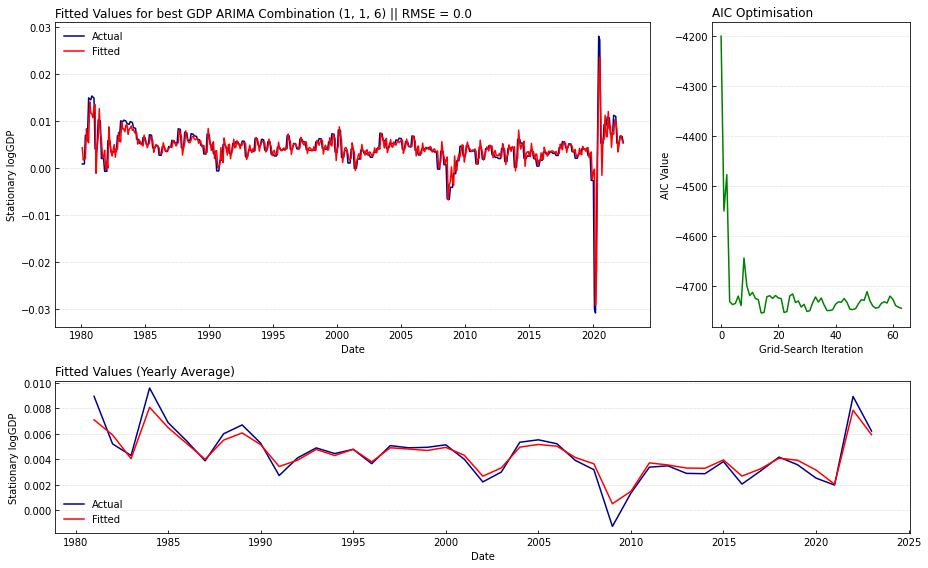

In [45]:
# visualize the model training
plot_model("GDP", model_data, aic_optimising, best_rmse)

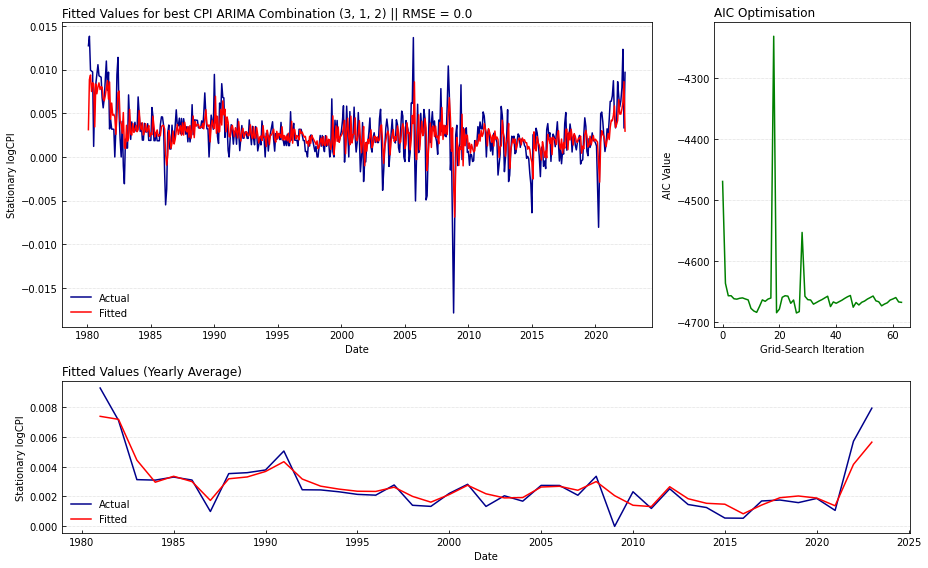

In [46]:
plot_model("CPI", model_data, aic_optimising, best_rmse)

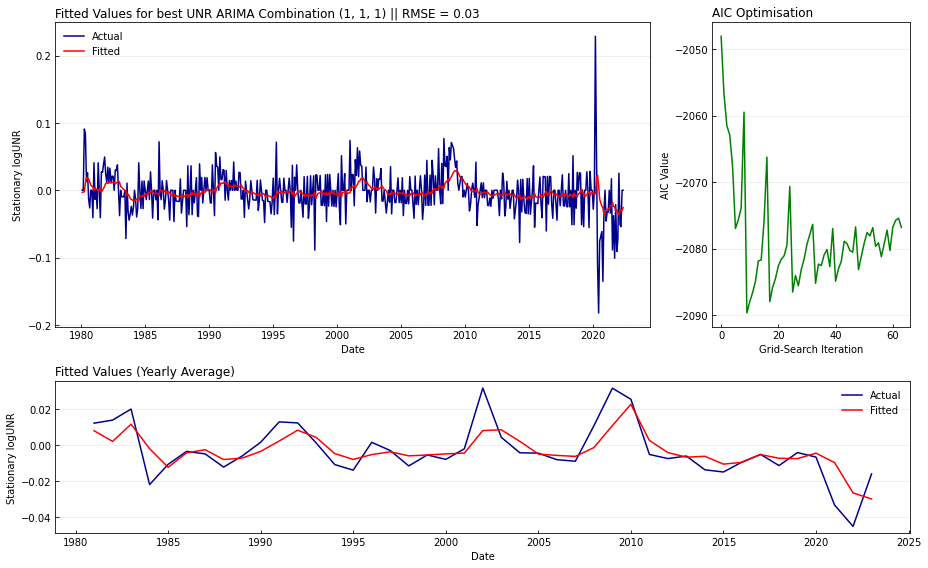

In [47]:
plot_model("UNR", model_data, aic_optimising, best_rmse)

In [48]:
# good forecasting methods will yield residuals with the following properties:
# 1. The residuals are uncorrelated (otherwise there is information left)
# 2. The residuals have zero mean (otherwise the forecasts are biased)
# 3. The residuals have constant variance (useful, but not necessary)
# 4. The residuals are normally distributed (useful, but not necessary)
def plot_residuals(indicator, data):
    """
    Several plots for residuals to understand if model adheres to ARIMA best-practices 
    
    1. Plots Density/Hist plots of residuals vs normality 
    2. Plots ACF to observe correlations (or hopefully lack thereof)
    3. Plots residuals through time 
    """
    
    residuals = data[indicator]
    
    # Engaging subplots 
    gs = gridspec.GridSpec(2, 2, height_ratios = [2, 1])
    plt.figure(figsize = (13,8))

    
    # Plot 1 - Residual Distribution (KDE)
    ax1 = plt.subplot(gs[0, 0])
    ax1.set_title("Density of Residuals", loc = "left")
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    sns.distplot(residuals, hist = True, kde = True, color='darkblue', ax = ax1, hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 2})
    np.random.seed(0)
    normal_sample = np.random.normal(np.mean(residuals),np.std(residuals), 249)
    sns.kdeplot(normal_sample, color = "red", shade=False, ax = ax1) 
    
    # Plot 2 - Autocorrelation Function
    ax2 = plt.subplot(gs[0, 1])
    acf_plot(residuals, ax = ax2, title = "Autocorrelation Function of Residuals")

    ax3 = plt.subplot(gs[1, :])
    
    # plot actual and fitted values on yearly average
    ax3.plot(residuals, "bo", color = "darkblue")
    ax3.axhline(y = 0, color = "red", linestyle = "--")
    ax3.set_title("Residuals", loc = "left")
    ax3.set_xlabel("Date")
    ax3.tick_params(direction = "in")
    ax3.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    return plt.tight_layout()

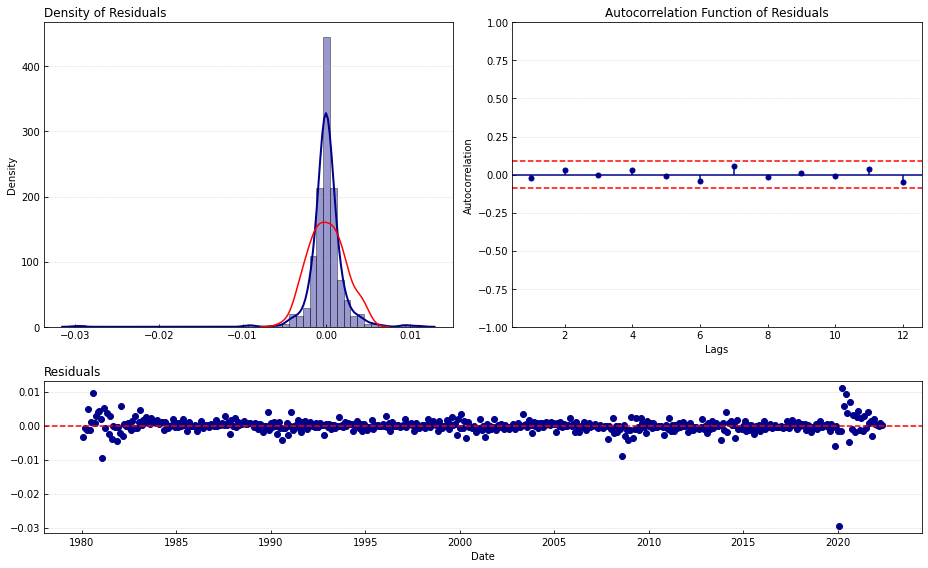

In [49]:
# residuals for chosen parameter combination on full training data
plot_residuals("GDP", best_resid)

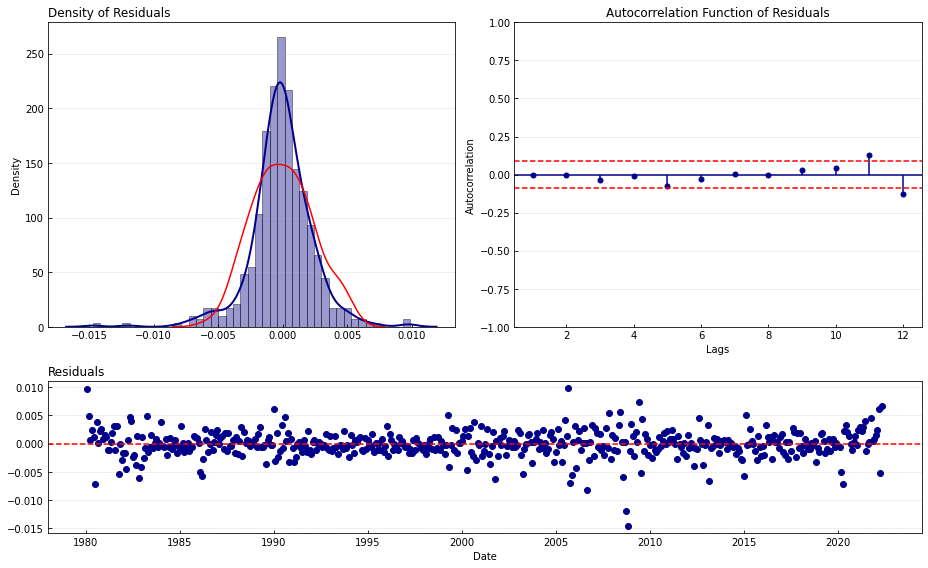

In [50]:
plot_residuals("CPI", best_resid)

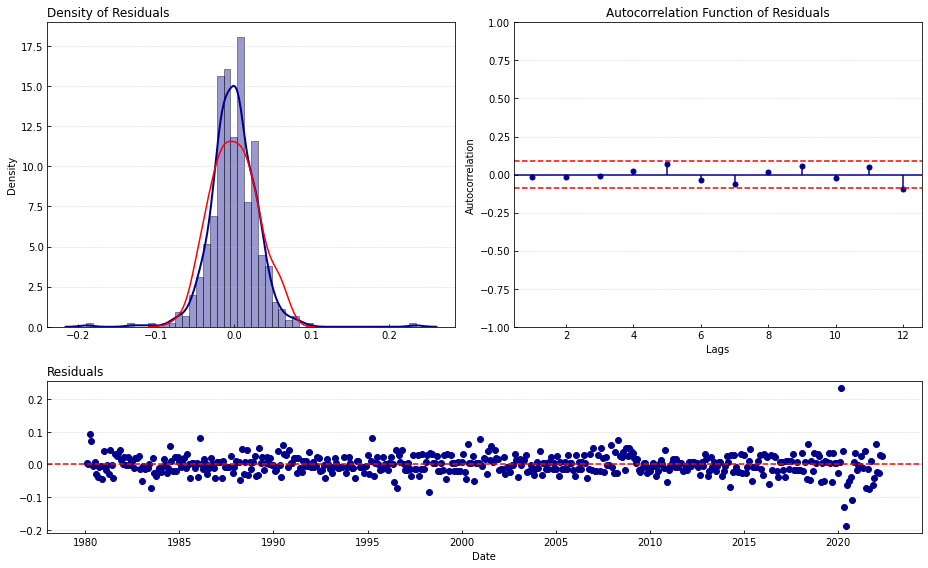

In [51]:
plot_residuals("UNR", best_resid)

In [73]:
gq_test = {}
jb = {}
lqb = {}

In [121]:
def gq(indicator, residuals = best_resid): 
    """
    Goldfeld-Quandt Test to test whether variance is the same in 2 subsamples 
    Indictation for the presence of Heteroscedasticity
    """
    # Goldfeld-Quandt Test for residual variance 
    keys = ['GQ F-statistic', 'GQ p-value']
    # 0<split<1 then split is interpreted as fraction of the observations in the first sample
    goldfeldquandt_test = list(sm.stats.het_goldfeldquandt(residuals[indicator], residuals[indicator].index, split=0.5))
    gq_test[indicator] = dict(zip(keys, goldfeldquandt_test))
    
    return 

In [151]:
def gq(indicator, resid = best_resid):
    """
    Source code from statsmodels for Goldfeld-Quandt test for heteroskedasticity 
    """
    resid = resid[indicator]
    squared_resid = np.asarray(resid, dtype = float) ** 2
    if squared_resid.ndim == 1:
        squared_resid = squared_resid.reshape(-1, 1)
    nobs = len(resid)

    h = int(np.round(nobs * 1/3))

    numer_resid = squared_resid[-h:]
    numer_dof = (~np.isnan(numer_resid)).sum(axis = 0)
    numer_squared_sum = np.nansum(numer_resid, axis = 0)

    denom_resid = squared_resid[:h]
    denom_dof = (~np.isnan(denom_resid)).sum(axis = 0)
    denom_squared_sum = np.nansum(denom_resid, axis = 0)

    test_statistic = numer_squared_sum / denom_squared_sum

    from scipy.stats import f
    pval_lower = lambda test_statistics: f.cdf(test_statistics, numer_dof, denom_dof)
    pval_upper = lambda test_statistics: f.sf(test_statistics, numer_dof, denom_dof)
    p_value = 2 * np.minimum(pval_lower(test_statistic), pval_upper(test_statistic))
    
    keys = ['GQ F-statistic', 'GQ p-value']
    goldfeldquandt_test = (int(test_statistic), int(p_value))
    gq_test[indicator] = dict(zip(keys, goldfeldquandt_test))
    
    return

In [143]:
def jb_test(indicator, residuals = best_resid):
    """
    Performs Jarque-Bera Test for normality
    """
    keys = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skewness', 'Kurtosis']
    jarquebera_test = list(sm.stats.jarque_bera(residuals[indicator]))
    jb[indicator] = dict(zip(keys, jarquebera_test))
        
    return 

In [147]:
def lbq_test(indicator, residuals = best_resid):
    """
    Returns average result of Ljung-Box-Q test for autocorrelation
    """
    keys = ["Ljung-Box t-statistic", "Ljung-Box p-value"]
    q_test= sm.stats.acorr_ljungbox(residuals[indicator])
    lbq_t = (q_test["lb_stat"].mean(), q_test["lb_pvalue"].mean())
    lqb[indicator] =  dict(zip(keys, lbq_t))
    
    return

In [148]:
for indicator in best_resid:
    gq(indicator, resid = best_resid)
    jb_test(indicator, residuals = best_resid)
    lbq_test(indicator, residuals = best_resid)
    print("done!")

done!
done!
done!


In [150]:
jb_test_df = round(pd.DataFrame(jb), 3)
lbq_test_df = round(pd.DataFrame(lqb), 3)
gq_test_df = round(pd.DataFrame(gq_test), 3)
diagnostic_tests = pd.concat([jb_test_df, lbq_test_df, gq_test_df])
diagnostic_tests

,GDP,CPI,UNR
Jarque-Bera,92987.234,601.249,1906.700
Chi^2 two-tail prob.,0.000,0.000,0.000
Skewness,-4.356,-0.589,0.262
Kurtosis,68.705,8.198,12.477
Ljung-Box t-statistic,2.073,2.836,3.563
Ljung-Box p-value,0.863,0.830,0.725
GQ F-statistic,2.000,1.000,2.000
GQ p-value,0.000,0.000,0.000


## Out-of-Sample Forecasting

In [178]:
def make_forecast(y_pred, indicator, alpha, full_data, n_steps, test_set = macro_test):
    """
    Makes and prints forecast
    
    Inputs:
    y_pred - forecasted values
    indicator - name of indicator (eg GDP)
    alpha - significance level
    """
    
    future = pd.DataFrame()
    future[f"Forecasted_{indicator}"] = y_pred.predicted_mean
    future[["CI_lower","CI_upper"]]  = y_pred.conf_int(alpha = alpha)
    if indicator != "X":
        future = np.exp(future)
    if n_steps > len(test_set[indicator]):
        empty = [None]*(n_steps-len(test_set[indicator]))
        temp = list(test_set[indicator])
        new = temp.extend(empty)
        future[f"Actual_{indicator}"] = new
    else:
        future[f"Actual_{indicator}"] = test_set[indicator]
    future["Difference"] = future[f"Actual_{indicator}"] - future[f"Forecasted_{indicator}"]
    
    return round(future, 3)

In [179]:
len(macro_test["GDP"])

2

In [243]:
def plot_forecast(indicator, full_data, best_model, n_steps = 5, periods = 497, alpha = 0.05):
    """
    Plots forecast for indicator over a given period
    
    Inputs: 
    indicator - name of indicator for plotting (eg GDP)
    full_data - entire logged time series for given indicator (eg macro.logGDP)
    best_model - trained ARIMA Model for predictions
    n_steps - number of periods to be forecast 
    periods - number of periods to be displayed
    significance level for confidence interval
    """
    best_model = best_model[indicator]
    
    # Forecasting 
    y_pred = best_model.get_forecast(steps = n_steps)
    future = make_forecast(y_pred, indicator, alpha, full_data, n_steps)
    print(future.iloc[:,:3])
    
    # Plotting 
    if indicator != "X":
        ax = np.exp(full_data[periods:]).plot(label = "Observed", color = "r")
        np.exp(y_pred.predicted_mean).plot(ax = ax, style='k--', label = (f"{n_steps}-Step Forecast"), alpha = 1, figsize = (15, 8))
    else:
        ax = full_data[periods:].plot(label = "Observed", color = "r")
        y_pred.predicted_mean.plot(ax = ax, style='k--', label = (f"{n_steps}-Step Forecast"), alpha = 1, figsize = (15, 8))
        
    ax.fill_between(future.index, future["CI_lower"], future["CI_upper"], color = "b", alpha = 0.3)
    plt.legend(loc = "best")
    plt.title(f"{n_steps}-Month Forecast for {indicator}")
    
    return future, plt.show

In [244]:
future = {}

            Forecasted_GDP   CI_lower   CI_upper
2022-09-01       25663.720  25530.272  25797.864
2022-10-01       25664.446  25372.120  25960.140
2022-11-01       25790.884  25309.199  26281.737


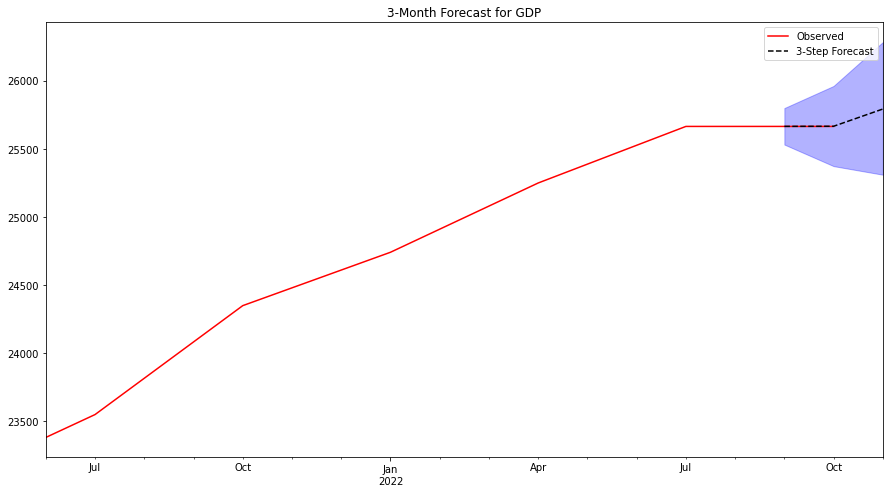

In [245]:
indicator = "GDP"
future[indicator], _ = plot_forecast(indicator, macro.logGDP, best_model, n_steps = 3)

In [250]:
future["GDP"].iloc[:,0:3]

,Forecasted_GDP,CI_lower,CI_upper
2022-09-01,25663.720,25530.272,25797.864
2022-10-01,25664.446,25372.120,25960.140
2022-11-01,25790.884,25309.199,26281.737


            Forecasted_CPI  CI_lower  CI_upper
2022-09-01         296.725   295.252   298.206
2022-10-01         297.393   294.542   300.271
2022-11-01         298.005   293.925   302.141


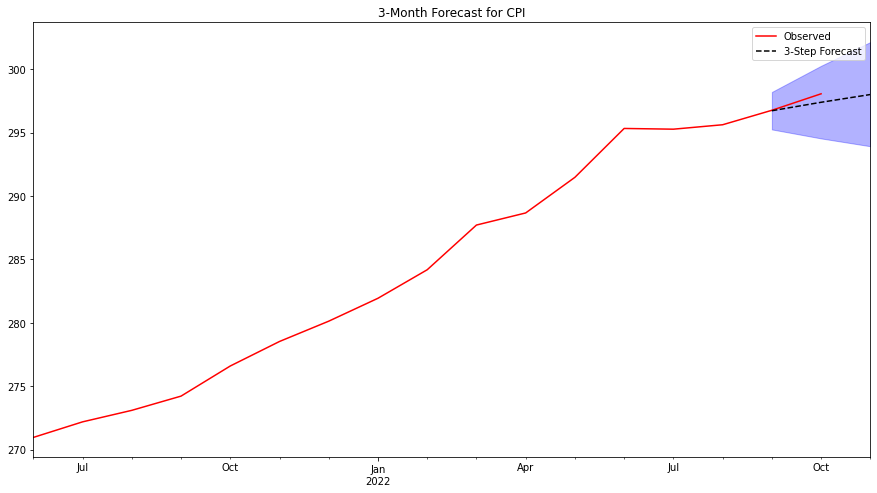

In [247]:
indicator = "CPI"
future[indicator], _ = plot_forecast(indicator, macro.logCPI, best_model, n_steps = 3)

            Forecasted_UNR  CI_lower  CI_upper
2022-09-01           3.734     3.306     4.218
2022-10-01           3.716     3.094     4.463
2022-11-01           3.726     2.978     4.660


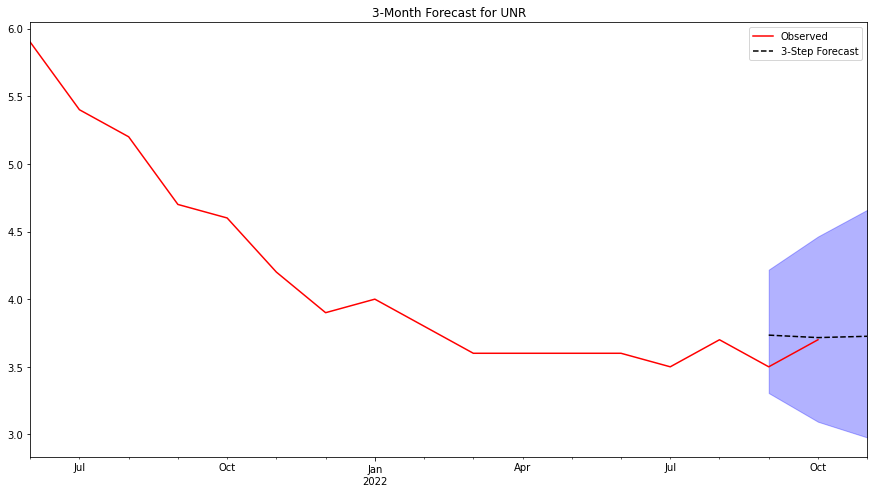

In [208]:
indicator = "UNR"
future[indicator], _ = plot_forecast(indicator, macro.logUNR, best_model, n_steps = 3)

            Forecasted_UNR  CI_lower  CI_upper
2022-06-01           3.567     3.098     4.036
2022-07-01           3.628     2.872     4.383
2022-08-01           3.571     2.529     4.614
2022-09-01           3.625     2.336     4.914
2022-10-01           3.574     2.084     5.064


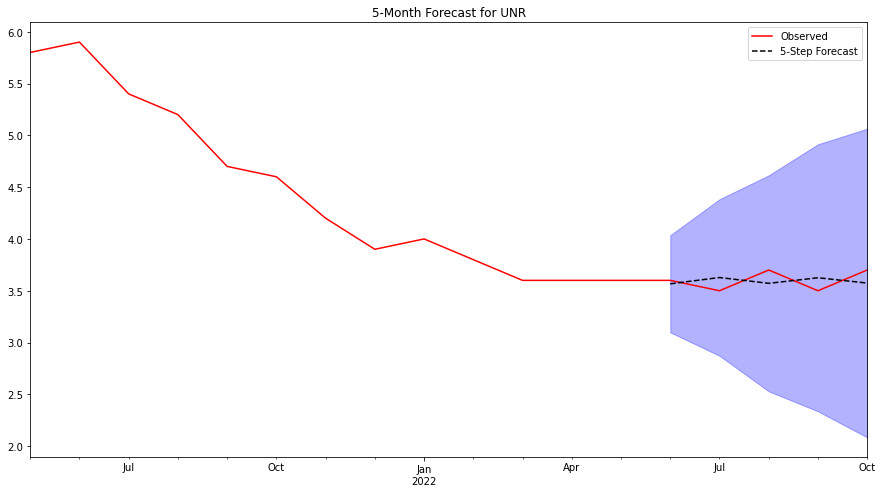

In [241]:
indicator = "UNR"
future[indicator], _ = plot_forecast(indicator, macro.UNR, best_model, n_steps = 5)

In [194]:
future["CPI"]

,Forecasted_CPI,CI_lower,CI_upper,Actual_CPI,Difference
2022-09-01,296.725,295.252,298.206,None,NaN
2022-10-01,297.393,294.542,300.271,None,NaN
2022-11-01,298.005,293.925,302.141,None,NaN


## Evaluation Metrics - Out-of-Sample Forecasting

In [209]:
def mape(y_true, y_pred, n_steps = 5):
    ape_list = []
    for i in range(len(y_pred)):
        ape = (abs((y_true[i]-y_pred[i])/y_true[i])) # absolute percentage error
        ape_list.append(ape)
        # Take the mean of a list of absolute percentage error & times 100
    return np.mean(ape_list)*100

In [210]:
def evaluate_forecast(y_true, y_pred):
    """
    Performs evaluations on forecast, comparing predicted and actual values through a wide array of metrics
    """
    results = pd.DataFrame(index = [f"{y_true.name} Forecast"])
    
    results["R^2"] = r2_score(y_true, y_pred)
    results['mean_absolute_error'] = np.mean(np.abs((y_true - y_pred) / y_true))*100
    results['median_absolute_error'] = median_absolute_error(y_true, y_pred)
    results['mse'] = mean_squared_error(y_true, y_pred)
    results["mape"] = mape(y_true, y_pred)
    results['msle'] = mean_squared_log_error(y_true, y_pred)
    results['rmse'] = np.sqrt(results['mse'])
    
    return round(results, 3)

### GDP Forecast Evaluation

In [406]:
future["GDP"]

,Forecasted_GDP,CI_lower,CI_upper,Actual_GDP,Difference
2022-06-01,25522.325,25390.104,25655.234,25525.018,2.693
2022-07-01,25655.193,25363.999,25949.731,25663.289,8.096
2022-08-01,25814.796,25334.268,26304.439,25663.289,-151.507
2022-09-01,25972.290,25348.792,26611.124,25663.289,-309.001
2022-10-01,26127.694,25378.623,26898.876,25663.289,-464.405


In [73]:
indicator = "GDP"
evaluate_forecast(future[indicator][f"Actual_{indicator}"], future[indicator][f"Forecasted_{indicator}"])

,R^2,mean_absolute_error,median_absolute_error,mse,mape,msle,rmse
Actual_GDP Forecast,-19.356,0.702,146.541,62270.917,0.702,0.0,249.541


In [305]:
# Chopped outliers
indicator = "GDP"
evaluate_forecast(future[indicator][f"Actual_{indicator}"], future[indicator][f"Forecasted_{indicator}"])

,R^2,mean_absolute_error,median_absolute_error,mse,mape,msle,rmse
Actual_GDP Forecast,-6.656,0.452,103.019,23421.042,0.452,0.0,153.039


### CPI Forecast Evaluation

In [74]:
future["CPI"]

,Forecasted_CPI,CI_lower,CI_upper,Actual_CPI,Difference
2022-06-01,293.704,292.227,295.188,295.328,1.624
2022-07-01,295.982,293.322,298.666,295.271,-0.711
2022-08-01,297.972,294.184,301.809,295.620,-2.352
2022-09-01,300.101,295.262,305.019,296.761,-3.340
2022-10-01,302.174,296.257,308.208,298.062,-4.112


In [75]:
indicator = "CPI"
evaluate_forecast(future[indicator][f"Actual_{indicator}"], future[indicator][f"Forecasted_{indicator}"])

,R^2,mean_absolute_error,median_absolute_error,mse,mape,msle,rmse
Actual_CPI Forecast,-5.399,0.818,2.352,7.348,0.818,0.0,2.711


In [306]:
indicator = "CPI"
evaluate_forecast(future[indicator][f"Actual_{indicator}"], future[indicator][f"Forecasted_{indicator}"])

,R^2,mean_absolute_error,median_absolute_error,mse,mape,msle,rmse
Actual_CPI Forecast,-7.884,0.949,3.007,10.201,0.949,0.0,3.194


### UNR Forecast Evaluation

In [76]:
future["UNR"] # 

,Forecasted_UNR,CI_lower,CI_upper,Actual_UNR,Difference
2022-06-01,3.625,2.810,4.440,3.6,-0.025
2022-07-01,3.751,2.596,4.905,3.5,-0.251
2022-08-01,3.716,2.329,5.104,3.7,-0.016
2022-09-01,3.884,2.295,5.472,3.5,-0.384
2022-10-01,3.813,2.064,5.561,3.7,-0.113


In [77]:
# Stationary via Dickey-Fuller & ACF
indicator = "UNR"
evaluate_forecast(future[indicator][f"Actual_{indicator}"], future[indicator][f"Forecasted_{indicator}"])

,R^2,mean_absolute_error,median_absolute_error,mse,mape,msle,rmse
Actual_UNR Forecast,-4.603,4.465,0.113,0.045,4.465,0.002,0.212


In [95]:
# Stationary via ONLY Dickey-Fuller, rejected by ACF 
indicator = "UNR"
evaluate_forecast(future[indicator][f"Actual_{indicator}"], future[indicator][f"Forecasted_{indicator}"])

,R^2,mean_absolute_error,median_absolute_error,mse,mape,msle,rmse
Actual_UNR Forecast,-4.196,4.916,0.19,0.042,4.916,0.002,0.204


In [390]:
# log diff Stationary via ONLY Dickey-Fuller, rejected by ACF 
indicator = "UNR"
evaluate_forecast(future[indicator][f"Actual_{indicator}"], future[indicator][f"Forecasted_{indicator}"])

,R^2,mean_absolute_error,median_absolute_error,mse,mape,msle,rmse
Actual_UNR Forecast,-0.01,2.245,0.099,0.008,2.245,0.0,0.09


In [307]:
# Differenced , interpolated extreme values 0.999%
indicator = "UNR"
evaluate_forecast(future[indicator][f"Actual_{indicator}"], future[indicator][f"Forecasted_{indicator}"])

,R^2,mean_absolute_error,median_absolute_error,mse,mape,msle,rmse
Actual_UNR Forecast,-0.496,2.477,0.041,0.012,2.477,0.001,0.109


## Train on full dataset for predictions

In [211]:
reduced_macro = macro[["CPI", "UNR", "logCPI", "logUNR"]]
reduced_macro.tail()

,CPI,UNR,logCPI,logUNR
2022-06-01,295.328,3.6,5.688087,1.280934
2022-07-01,295.271,3.5,5.687894,1.252763
2022-08-01,295.620,3.7,5.689075,1.308333
2022-09-01,296.761,3.5,5.692927,1.252763
2022-10-01,298.062,3.7,5.697302,1.308333


In [212]:
# Train/Test Split (removing September and October [Oct CPI releases on Nov10])
reduced_macro_test = reduced_macro.tail(2)
reduced_macro_dev = reduced_macro.drop(reduced_macro_test.index)

In [213]:
reduced_macro_dev.tail()

,CPI,UNR,logCPI,logUNR
2022-04-01,288.663,3.6,5.665260,1.280934
2022-05-01,291.474,3.6,5.674951,1.280934
2022-06-01,295.328,3.6,5.688087,1.280934
2022-07-01,295.271,3.5,5.687894,1.252763
2022-08-01,295.620,3.7,5.689075,1.308333


In [214]:
reduced_macro_test.head()

,CPI,UNR,logCPI,logUNR
2022-09-01,296.761,3.5,5.692927,1.252763
2022-10-01,298.062,3.7,5.697302,1.308333


In [215]:
reduced_best_model = {}

### CPI 2-month forecast

In [216]:
indicator = "CPI"
reduced_best_model[indicator] = ARIMA(reduced_macro_dev.logCPI, order = (3, 1, 2)).fit()
print(reduced_best_model[indicator].summary())

                               SARIMAX Results                                
Dep. Variable:                 logCPI   No. Observations:                  512
Model:                 ARIMA(3, 1, 2)   Log Likelihood                2327.156
Date:                Mon, 28 Nov 2022   AIC                          -4642.312
Time:                        18:51:49   BIC                          -4616.894
Sample:                    01-01-1980   HQIC                         -4632.347
                         - 08-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5213      0.122      4.257      0.000       0.281       0.761
ar.L2          0.2041      0.188      1.088      0.277      -0.164       0.572
ar.L3          0.1021      0.108      0.948      0.3

In [217]:
y_pred = reduced_best_model[indicator].get_forecast(steps = 2)
future_cpi = make_forecast(y_pred, indicator, 0.05, reduced_macro, 2, reduced_macro_test)
future_cpi

,Forecasted_CPI,CI_lower,CI_upper,Actual_CPI,Difference
2022-09-01,296.725,295.252,298.206,296.761,0.036
2022-10-01,297.393,294.542,300.271,298.062,0.669


In [219]:
evaluate_forecast(future_cpi[f"Actual_{indicator}"], future_cpi[f"Forecasted_{indicator}"])

,R^2,mean_absolute_error,median_absolute_error,mse,mape,msle,rmse
Actual_CPI Forecast,0.47,0.118,0.353,0.224,0.118,0.0,0.474


In [251]:
guesses_cpi = [297, 298]
evaluate_forecast(future_cpi[f"Actual_{indicator}"], guesses_cpi)

,R^2,mean_absolute_error,median_absolute_error,mse,mape,msle,rmse
Actual_CPI Forecast,0.928,0.051,0.15,0.03,0.051,0.0,0.175


### Unemployment 2-month forecast 

In [255]:
indicator = "UNR"
reduced_best_model[indicator] = ARIMA(reduced_macro_dev.logUNR, order = (1, 1, 1)).fit()
print(reduced_best_model[indicator].summary())

                               SARIMAX Results                                
Dep. Variable:                 logUNR   No. Observations:                  512
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 694.281
Date:                Mon, 28 Nov 2022   AIC                          -1382.562
Time:                        21:07:52   BIC                          -1369.853
Sample:                    01-01-1980   HQIC                         -1377.580
                         - 08-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5323      0.106     -4.999      0.000      -0.741      -0.324
ma.L1          0.6538      0.104      6.308      0.000       0.451       0.857
sigma2         0.0039   2.96e-05    130.787      0.0

In [256]:
y_pred = reduced_best_model[indicator].get_forecast(steps = 2)
future_unr = make_forecast(y_pred, indicator, 0.05, reduced_macro, 2, reduced_macro_test)
future_unr

,Forecasted_UNR,CI_lower,CI_upper,Actual_UNR,Difference
2022-09-01,3.734,3.306,4.218,3.5,-0.234
2022-10-01,3.716,3.094,4.463,3.7,-0.016


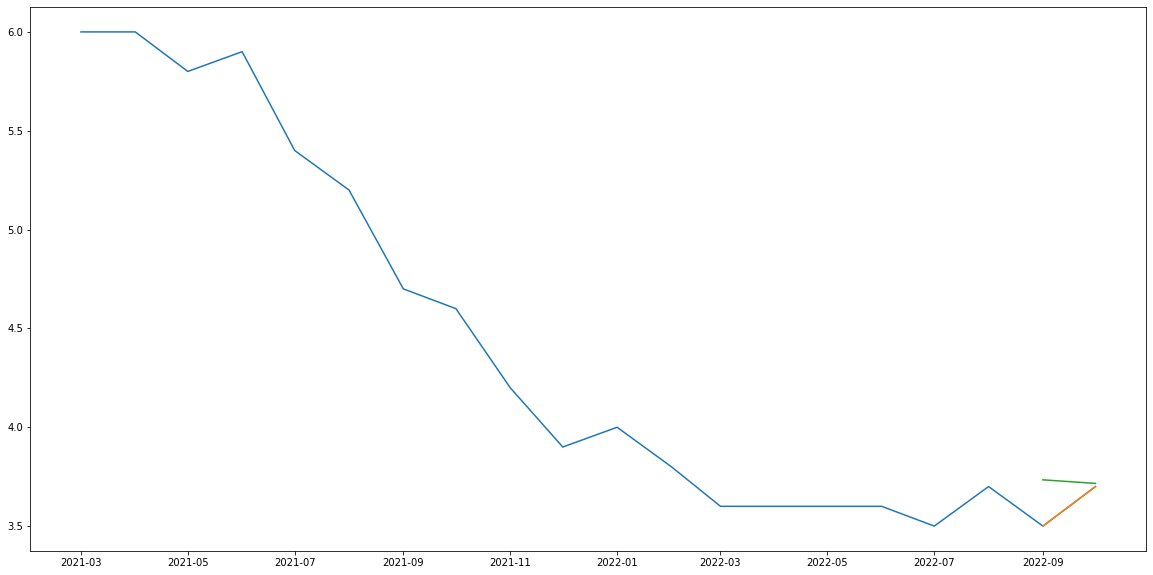

In [237]:
plt.figure(figsize = (20, 10))
plt.plot(reduced_macro["UNR"].tail(20))
plt.plot(future_unr[f"Actual_{indicator}"])
plt.plot(future_unr[f"Forecasted_{indicator}"])

In [238]:
evaluate_forecast(future_unr[f"Actual_{indicator}"], future_unr[f"Forecasted_{indicator}"])

,R^2,mean_absolute_error,median_absolute_error,mse,mape,msle,rmse
Actual_UNR Forecast,-1.751,3.559,0.125,0.028,3.559,0.001,0.166


In [259]:
guesses_unr = [3.65, 3.9]
evaluate_forecast(future_unr[f"Actual_{indicator}"], guesses_unr)

,R^2,mean_absolute_error,median_absolute_error,mse,mape,msle,rmse
Actual_UNR Forecast,-2.125,4.846,0.175,0.031,4.846,0.001,0.177
